In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from time import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
# Read the CSV files
plugcsv = 'PLUG.csv'  #plug
neecsv = 'NEE.csv' #next energy 
fslrcsv = 'FSLR.csv' # first solar
plug = pd.read_csv(plugcsv)
nee = pd.read_csv(neecsv)
fslr=pd.read_csv(fslrcsv)
plug['name'] = 'plug'
nee['name'] = 'nee'
fslr['name'] = 'fslr'
df = pd.concat([plug, nee, fslr], ignore_index=True)

In [3]:
df['Date'] = pd.to_datetime(df['Date'])

df['day'] = df['Date'].dt.day
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year
# Extract day, month, and year


# Set the 'Date' as the index
df.set_index('Date', inplace=True)

In [4]:
print("\nSummary Statistics:", df.describe())  # Basic stats like mean, std, min, max
print("\nMissing values in each column:", df.isnull().sum())


Summary Statistics:               Open         High          Low        Close    Adj Close  \
count  8793.000000  8793.000000  8793.000000  8793.000000  8793.000000   
mean     45.350001    46.130077    44.561927    45.340819    43.736434   
std      43.484448    44.361142    42.631937    43.484006    43.501449   
min       0.120000     0.130000     0.120000     0.120000     0.120000   
25%       9.150000     9.400000     8.840000     9.130000     9.130000   
50%      38.360001    38.834999    37.750000    38.330002    35.002052   
75%      65.519997    66.702499    63.950001    65.620003    63.958538   
max     300.500000   306.769989   296.399994   300.709991   300.709991   

             Volume          day        month         year  
count  8.793000e+03  8793.000000  8793.000000  8793.000000  
mean   8.631250e+06    15.709314     6.429205  2018.329922  
std    1.222132e+07     8.747566     3.405693     3.366083  
min    7.890000e+04     1.000000     1.000000  2013.000000  
25%    

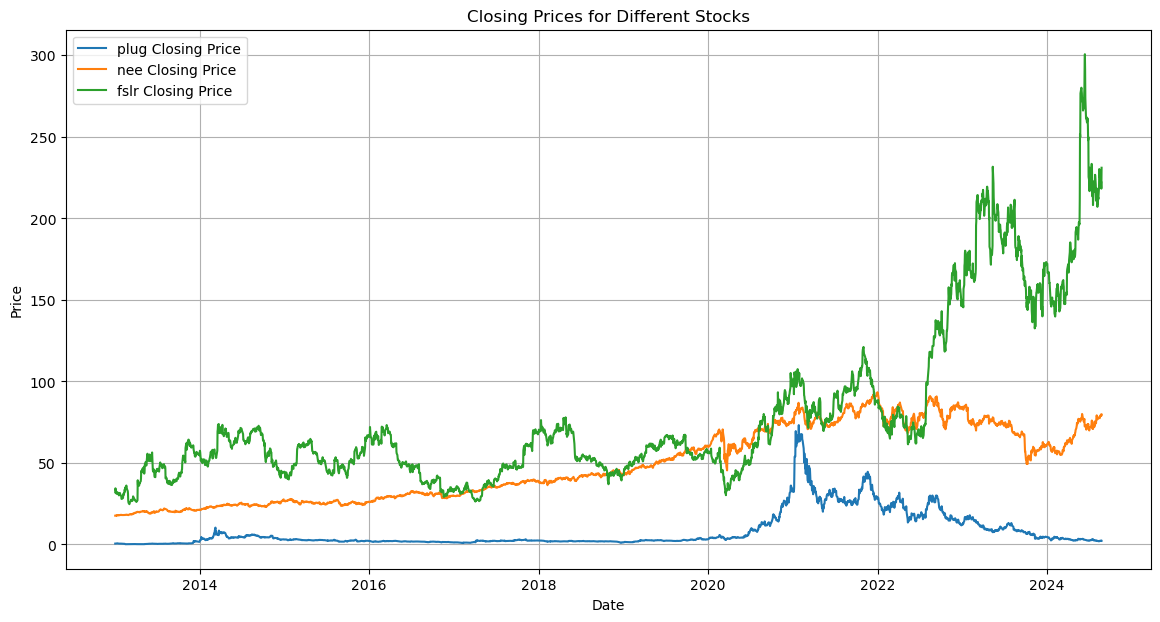

In [5]:
plt.figure(figsize=(14, 7))
for stock in df['name'].unique():
    stock_data = df[df['name'] == stock]
    plt.plot(stock_data.index, stock_data['Close'], label=f'{stock} Closing Price')

plt.title('Closing Prices for Different Stocks')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


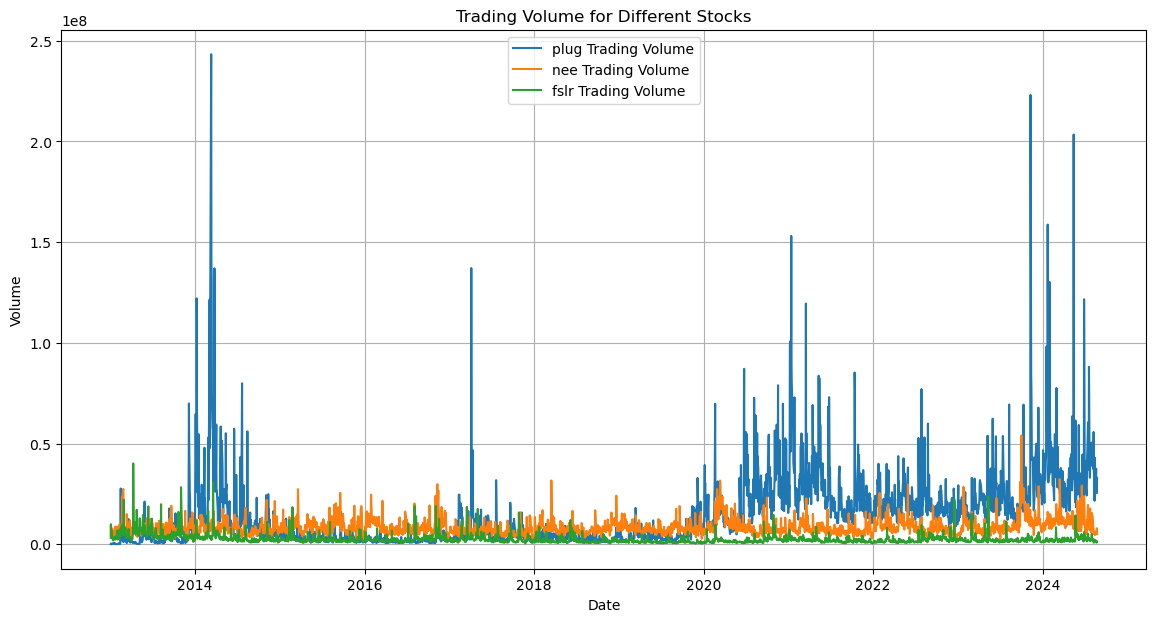

In [6]:
plt.figure(figsize=(14, 7))
for stock in df['name'].unique():
    stock_data = df[df['name'] == stock]
    plt.plot(stock_data.index, stock_data['Volume'], label=f'{stock} Trading Volume')

plt.title('Trading Volume for Different Stocks')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# More Insights: For example, let's find the stock with the highest average closing price
avg_closing_price = df.groupby('name')['Close'].mean()
print("\nAverage Closing Price per Stock:")
print(avg_closing_price)




Average Closing Price per Stock:
name
fslr    79.129461
nee     48.807806
plug     8.085189
Name: Close, dtype: float64


In [8]:
# Calculate Daily Returns (percentage change)
df['Daily Return'] = df['Close'].pct_change() * 100

In [9]:
# Insights on stock with the highest average return
avg_daily_return = df.groupby('name')['Daily Return'].mean()
print("\nAverage Daily Return per Stock:")
print(avg_daily_return)



Average Daily Return per Stock:
name
fslr    0.096320
nee     0.301385
plug    0.234237
Name: Daily Return, dtype: float64


### FEATURE ENGINEERING

In [10]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,name,day,month,year,Daily Return
Date,,,,,,,,,,,
2013-01-02,0.50,0.52,0.48,0.50,0.50,143300,plug,2,1,2013,NaN
2013-01-03,0.51,0.52,0.47,0.51,0.51,438000,plug,3,1,2013,2.000000
2013-01-04,0.53,0.53,0.52,0.53,0.53,157300,plug,4,1,2013,3.921569
2013-01-07,0.53,0.54,0.51,0.53,0.53,131800,plug,7,1,2013,0.000000
2013-01-08,0.53,0.59,0.51,0.54,0.54,230200,plug,8,1,2013,1.886792


In [11]:


#df['Daily Return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1#df['Adj Close'].pct_change()
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
#df.groupby('is_quarter_end').mean()


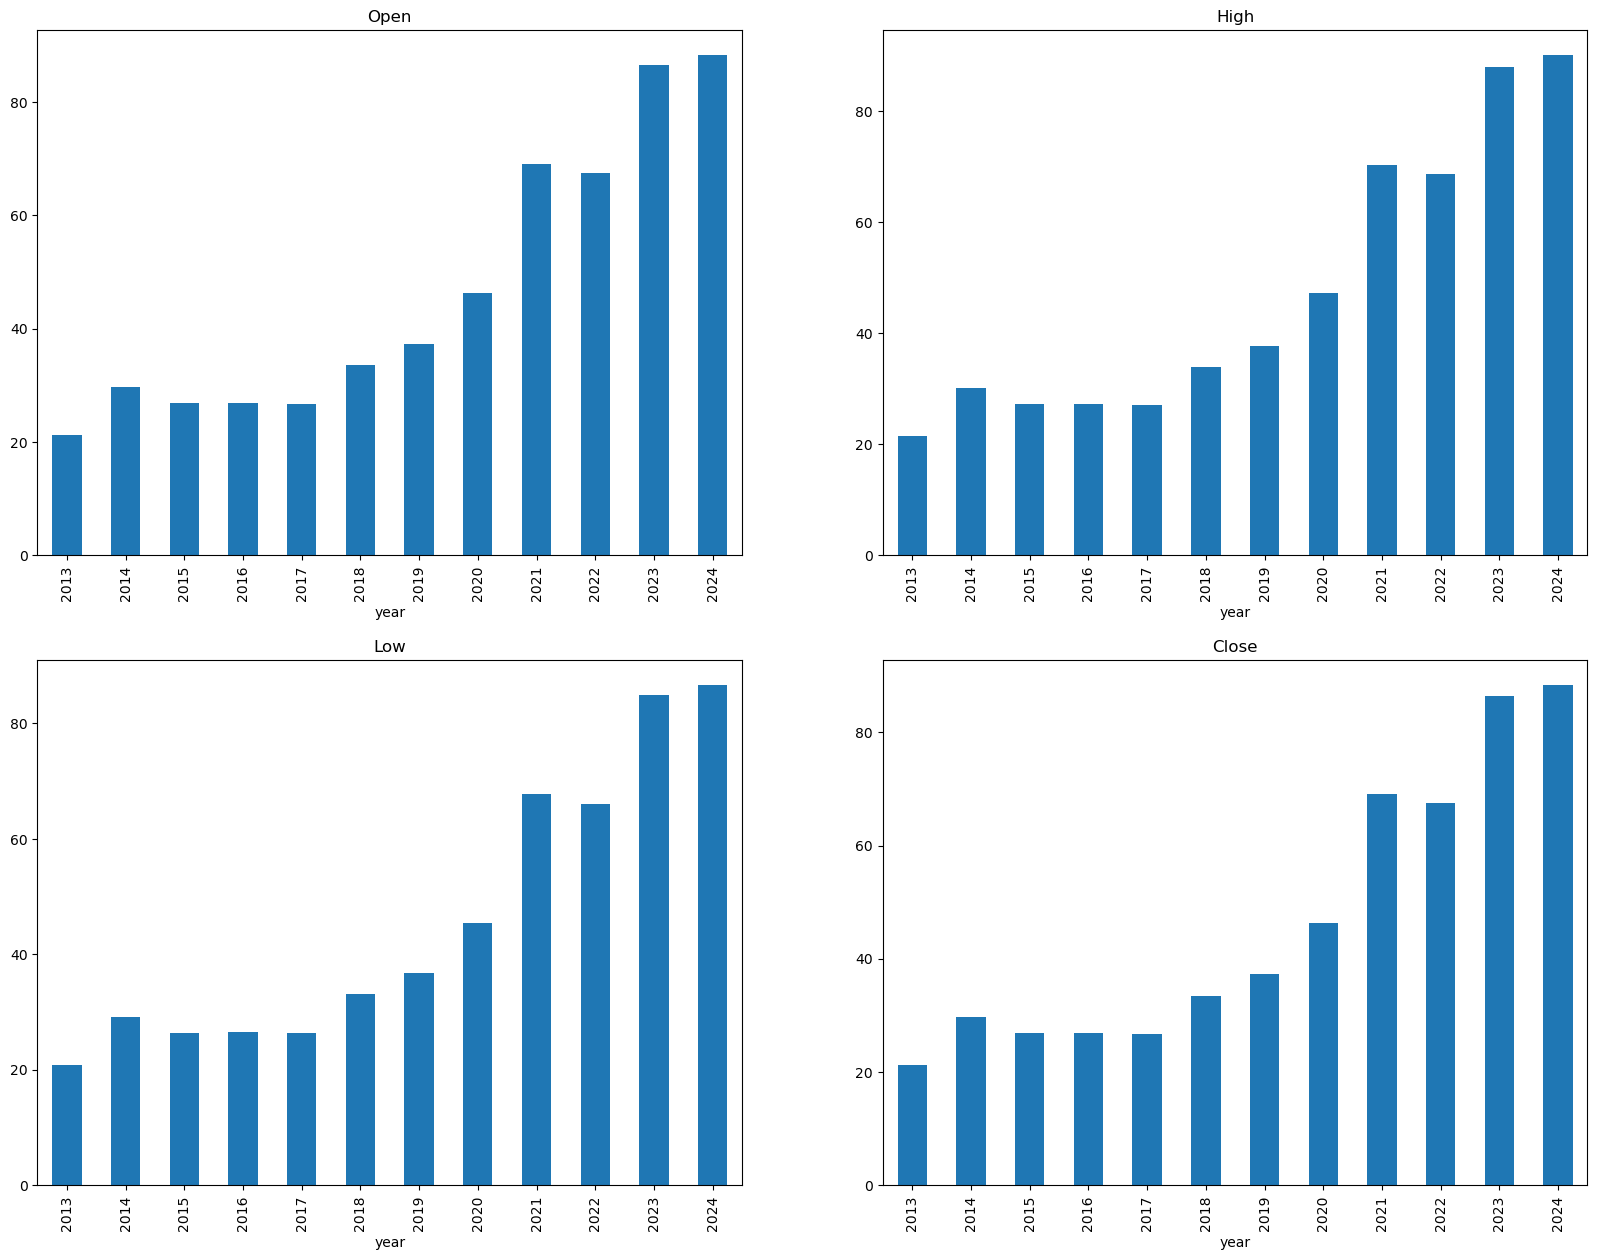

In [12]:
data_grouped = df.groupby('year').mean()
plt.subplots(figsize=(20,15))

for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2,2,i+1)
    data_grouped[col].plot.bar()
    plt.title(f'{col}')
    
plt.savefig('allovertime.png')
plt.show()


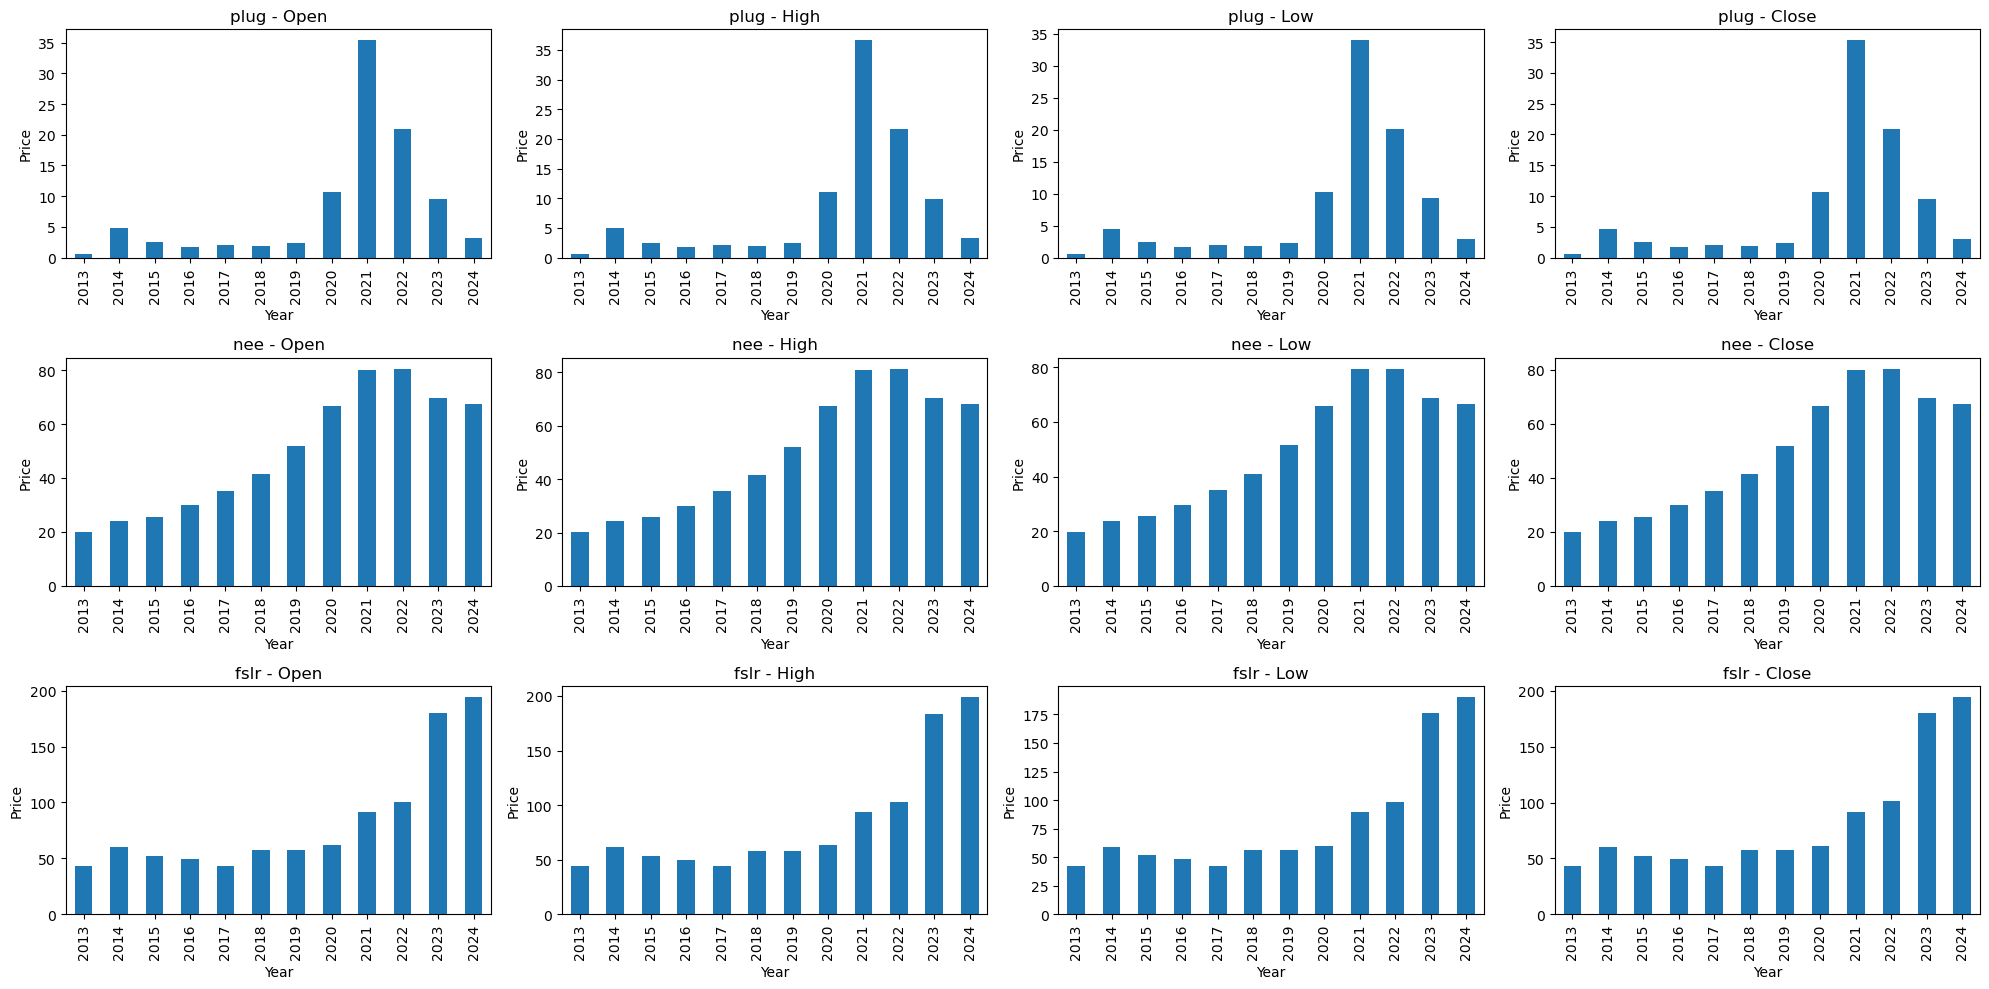

In [13]:
data_grouped = df.groupby(['year', 'name']).mean()

# Plot the results
plt.subplots(figsize=(20, 10))

# Loop through each ticker to create subplots
tickers = df['name'].unique()  # Get unique tickers
for i, ticker in enumerate(tickers):
    # Select the data for the current ticker
    ticker_data = data_grouped.xs(ticker, level='name')
    # Create subplots for Open, High, Low, Close prices
    for j, col in enumerate(['Open', 'High', 'Low', 'Close']):
        plt.subplot(len(tickers), 4, i*4 + j + 1)  # Adjust position for each subplot
        ticker_data[col].plot.bar()
        plt.title(f'{ticker} - {col}')
        plt.xlabel('Year')
        plt.ylabel('Price')

# Display the plot
plt.tight_layout()
plt.savefig('singleovertime.png')
plt.show()



In [14]:
df['open-close']  = df['Open'] - df['Close']
df['low-high']  = df['Low'] - df['High']
df['volume-close'] = df['Volume'] * df['Close']
#df['binary'] = np.where(df['Close'].shift(-1) > df['Close'], 1,0)
df[['Open', 'Close', 'High', 'Low', 'Volume', 'open-close', 'low-high', 'volume-close']].corr()

,Open,Close,High,Low,Volume,open-close,low-high,volume-close
Open,1.000000,0.999334,0.999645,0.999679,-0.221686,0.018526,-0.794649,0.318074
Close,0.999334,1.000000,0.999725,0.999654,-0.220946,-0.017969,-0.796768,0.321351
High,0.999645,0.999725,1.000000,0.999542,-0.218033,-0.001908,-0.804595,0.322975
Low,0.999679,0.999654,0.999542,1.000000,-0.224988,0.000963,-0.786249,0.315416
Volume,-0.221686,-0.220946,-0.218033,-0.224988,1.000000,-0.020334,0.037056,0.487927
open-close,0.018526,-0.017969,-0.001908,0.000963,-0.020334,1.000000,0.057834,-0.089703
low-high,-0.794649,-0.796768,-0.804595,-0.786249,0.037056,0.057834,1.000000,-0.405227
volume-close,0.318074,0.321351,0.322975,0.315416,0.487927,-0.089703,-0.405227,1.000000


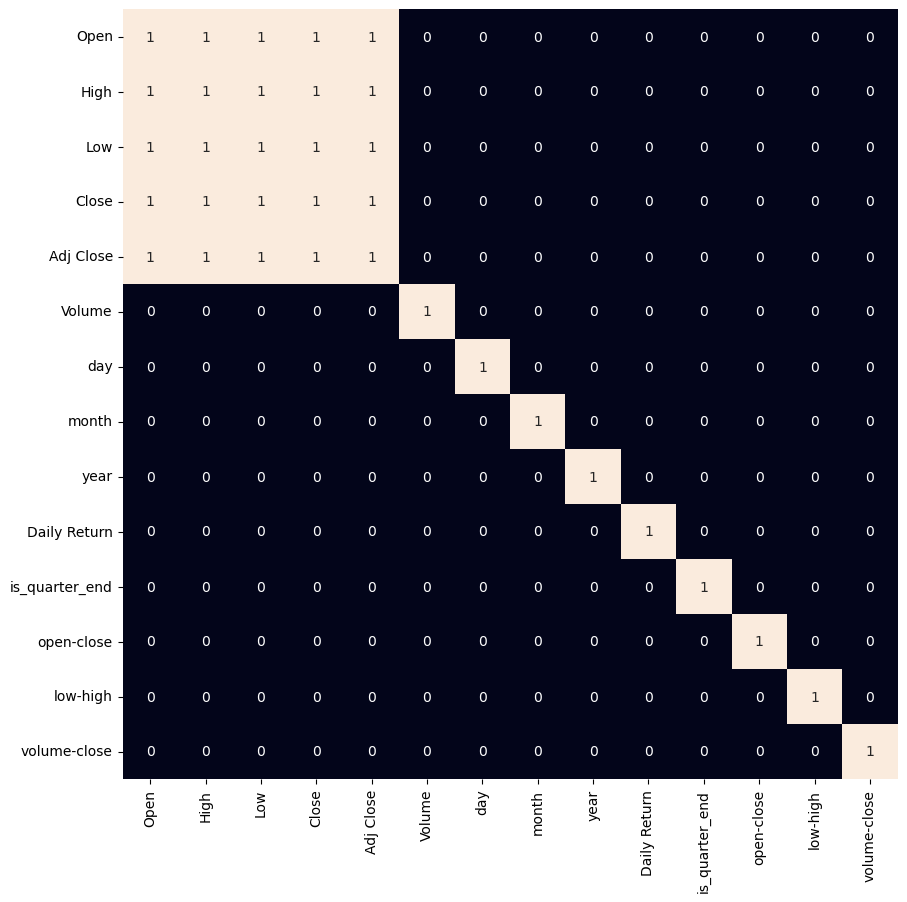

In [15]:

plt.figure(figsize=(10, 10)) 

# As our concern is with the highly 
# correlated features only so, we will visualize 
# our heatmap as per that criteria only. 
sb.heatmap(df.corr() > 0.75, annot=True, cbar=False)

plt.savefig('correlation.png')

plt.show()



In [16]:
#df[df['Close'] != df['Adj Close']] #same values

### PCA

In [17]:
features = df[['Open', 'High', 'Low']]
pca = PCA(n_components=1)  # Reduce to 3 principal components 
principal_components = pca.fit_transform(features)

df_pca = pd.DataFrame(data=principal_components, columns=['PC'])

In [18]:
df = df.reset_index(drop=True)

df = pd.concat([df, df_pca], axis=1)


In [19]:

# Standardizing the features
feature_scaler = StandardScaler()
df[['open-close', 'low-high','volume-close']] = feature_scaler.fit_transform(df[['open-close', 'low-high','volume-close']])


In [20]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,name,day,month,year,Daily Return,is_quarter_end,open-close,low-high,volume-close,PC
0,0.50,0.52,0.48,0.50,0.50,143300,plug,2,1,2013,NaN,0,-0.005786,0.703139,-0.739580,-77.685168
1,0.51,0.52,0.47,0.51,0.51,438000,plug,3,1,2013,2.000000,0,-0.005786,0.698538,-0.739171,-77.685054
2,0.53,0.53,0.52,0.53,0.53,157300,plug,4,1,2013,3.921569,0,-0.005786,0.716943,-0.739549,-77.639331
3,0.53,0.54,0.51,0.53,0.53,131800,plug,7,1,2013,0.000000,0,-0.005786,0.707741,-0.739585,-77.639101
4,0.53,0.59,0.51,0.54,0.54,230200,plug,8,1,2013,1.886792,0,-0.012088,0.684734,-0.739438,-77.609661


### MODELS

In [21]:
unique_tickers = df['name'].unique()

rf = RandomForestRegressor()
linreg_model = LinearRegression()

results = []

for ticker in unique_tickers:
    df_ticker = df[df['name'] == ticker]
    X = df_ticker[['open-close', 'low-high', 'is_quarter_end', 'volume-close', 'Volume', 'PC']]  # Features
    y = df_ticker['Close']  # Target: predicting the stock's closing price (numeric)
    
    X_train_mod, X_test_mod, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    tic = time()
    linreg_model.fit(X_train_mod, y_train)
    toc = time()
    linreg_training_time = toc - tic

    tic = time()
    rf.fit(X_train_mod, y_train)
    toc = time()
    rf_training_time = toc - tic

    logreg_pred_train = linreg_model.predict(X_train_mod)
    logreg_pred_test = linreg_model.predict(X_test_mod)

    rf_preds_train = rf.predict(X_train_mod)
    rf_preds_test = rf.predict(X_test_mod)

    rf_rmse_train = sqrt(mean_squared_error(y_train, rf_preds_train))
    rf_rmse_test = sqrt(mean_squared_error(y_test, rf_preds_test))
    rf_mae_train = mean_absolute_error(y_train, rf_preds_train)
    rf_mae_test = mean_absolute_error(y_test, rf_preds_test)
    rf_mse_train = mean_squared_error(y_train, rf_preds_train)
    rf_mse_test = mean_squared_error(y_test, rf_preds_test)
    
    linreg_rmse_train = sqrt(mean_squared_error(y_train, logreg_pred_train))
    linreg_rmse_test = sqrt(mean_squared_error(y_test, logreg_pred_test))
    linreg_mae_train = mean_absolute_error(y_train, logreg_pred_train)
    linreg_mae_test = mean_absolute_error(y_test, logreg_pred_test)
    linreg_mse_train = mean_squared_error(y_train, logreg_pred_train)
    linreg_mse_test = mean_squared_error(y_test, logreg_pred_test)

    print(f"Results for {ticker}:")
    print(f"Linear Regression RMSE: train = {linreg_rmse_train:.4f}, test = {linreg_rmse_test:.4f}")
    print(f"Random Forest RMSE: train = {rf_rmse_train:.4f}, test = {rf_rmse_test:.4f}")
    print(f"Linear Regression MAE: train = {linreg_mae_train:.4f}, test = {linreg_mae_test:.4f}")
    print(f"Random Forest MAE: train = {rf_mae_train:.4f}, test = {rf_mae_test:.4f}")
    print(f"Random Forest MSE: train = {rf_mse_train:.4f}, test = {rf_mse_test:.4f}")
    print(f"Linear Regression MSE: train = {linreg_mse_train:.4f}, test = {linreg_mse_test:.4f}")
    print("-" * 20)
    

#import pandas as pd
#results_df = pd.DataFrame(results)
#print(results_df)  


Results for plug:
Linear Regression RMSE: train = 0.1160, test = 0.1016
Random Forest RMSE: train = 0.1466, test = 0.3525
Linear Regression MAE: train = 0.0465, test = 0.0460
Random Forest MAE: train = 0.0476, test = 0.1316
Random Forest MSE: train = 0.0215, test = 0.1243
Linear Regression MSE: train = 0.0135, test = 0.0103
--------------------
Results for nee:
Linear Regression RMSE: train = 0.1229, test = 0.1480
Random Forest RMSE: train = 0.1153, test = 0.3105
Linear Regression MAE: train = 0.0767, test = 0.0784
Random Forest MAE: train = 0.0669, test = 0.1777
Random Forest MSE: train = 0.0133, test = 0.0964
Linear Regression MSE: train = 0.0151, test = 0.0219
--------------------
Results for fslr:
Linear Regression RMSE: train = 0.4336, test = 0.4095
Random Forest RMSE: train = 0.5367, test = 1.6174
Linear Regression MAE: train = 0.2605, test = 0.2584
Random Forest MAE: train = 0.2342, test = 0.6417
Random Forest MSE: train = 0.2880, test = 2.6158
Linear Regression MSE: train = 0.1

In [22]:
stocks = df['name'].unique()

def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, :])  
        y.append(data[i, 0])  # The next day's closing price
    return np.array(X), np.array(y)

predictions = {}
features = ['Close', 'open-close', 'low-high', 'is_quarter_end', 'volume-close','Volume', 'PC']  

for stock in stocks:
    stock_data = df[df['name'] == stock]
    stock_data_selected = stock_data[features]
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(stock_data_selected.values)
    
    time_step = 60
    X, y = create_dataset(scaled_data, time_step)
    X = X.reshape(X.shape[0], X.shape[1], len(features)) 

    train_size = int(len(X) * 0.75)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], len(features))))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer (closing price)
    model.compile(optimizer=Adam(), loss='mean_squared_error')

    model.fit(X_train, y_train, epochs=20, batch_size=32)

    predicted_stock_price = model.predict(X_test)
    predicted_stock_price = scaler.inverse_transform(np.hstack((predicted_stock_price, np.zeros((predicted_stock_price.shape[0], len(features)-1)))))
    true_stock_price = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features)-1)))))

    predictions[stock] = {'predicted': predicted_stock_price[:, 0], 'true': true_stock_price[:, 0]}
    
    mse = mean_squared_error(true_stock_price[:, 0], predicted_stock_price[:, 0])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_stock_price[:, 0], predicted_stock_price[:, 0])
    r2 = r2_score(true_stock_price[:, 0], predicted_stock_price[:, 0])

    print(f"Evaluation for {stock}:")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R²): {r2}")
    print('-' * 50)


Epoch 1/20
68/68 [==============================] - 10s 56ms/step - loss: 0.0075
Epoch 2/20
68/68 [==============================] - 4s 56ms/step - loss: 0.0020
Epoch 3/20
68/68 [==============================] - 4s 60ms/step - loss: 0.0014
Epoch 4/20
68/68 [==============================] - 4s 61ms/step - loss: 0.0012
Epoch 5/20
68/68 [==============================] - 4s 66ms/step - loss: 0.0010
Epoch 6/20
68/68 [==============================] - 4s 64ms/step - loss: 0.0010
Epoch 7/20
68/68 [==============================] - 4s 63ms/step - loss: 8.8911e-04
Epoch 8/20
68/68 [==============================] - 4s 62ms/step - loss: 8.4131e-04
Epoch 9/20
68/68 [==============================] - 4s 64ms/step - loss: 9.0188e-04
Epoch 10/20
68/68 [==============================] - 4s 63ms/step - loss: 9.8598e-04
Epoch 11/20
68/68 [==============================] - 5s 78ms/step - loss: 7.2997e-04
Epoch 12/20
68/68 [==============================] - 4s 64ms/step - loss: 7.5302e-04
Epoch 13/20
